
ilk deneme, elips1.pt'de kayıtlı. 0.05 başarı oranı, çok fena
ikinci denemede normalizasyonu kaldırdım. aynı sonuç, sorun var.

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [77]:
train_transform = transforms.Compose([
#     transforms.RandomRotation(10),
#     transforms.RandomHorizontalFlip(),
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #  GÖZDEN GEÇECEK
    transforms.Normalize([0,0,0], [1,1,1])
])

In [78]:
dataset = datasets.ImageFolder('shapes_dataset_LR',transform=train_transform)
torch.manual_seed(42)
train_data, test_data = torch.utils.data.random_split(dataset, [9000, 1000])

train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10)

In [79]:
len(train_data)

9000

In [80]:
train_data.dataset.classes

['0', '1', '2', '3', '4', '5']

In [89]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64,3,2,1) # 32
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,128,3,2) # 15
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128,256,3,2) # 7
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256,512,3,2) # 3
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512,6,3,1) # 3
        self.bn5 = nn.BatchNorm2d(6)
    def forward(self,X): # POOLING YERINE STRIDE KULLAN
        X = self.conv1(X)
        X = self.bn1(X)
        X = F.relu(X)
        
        X = self.conv2(X)
        X = self.bn2(X)
        X = F.relu(X)
        
        X = self.conv3(X)
        X = self.bn3(X)
        X = F.relu(X)
        
        X = self.conv4(X)
        X = self.bn4(X)
        X = F.relu(X)
        
        X = self.conv5(X)
        X = self.bn5(X)
        X = F.relu(X)
        X = X.view(-1,6)
#         X = X.view(-1,56*56*384)
        
        return F.log_softmax(X,dim=1)
        

In [90]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)

In [91]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 6, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [92]:
import time
start_time = time.time()

epochs = 30

# # LIMITS on num of batches, sadece daha hızlı bitsin diye, bize lazım değil
# max_trn_batch = 800 # batch 10 images --> 8000 images
# max_tst_batch = 300 # 3000 max images

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        
#         # optional limit number of batches
#         if b == max_trn_batch:
#             break
            
        b+=1
        
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%300 == 0:
            acc = trn_corr.item()/b
            print(f'Epoch {i} batch {b} loss: {loss.item()} accuracy: {acc}')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
#             if b == max_tst_batch:
#                 break
        
            y_val = CNNmodel(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'total time = {total_time/60} mins')

Epoch 0 batch 300 loss: 1.664625883102417 accuracy: 2.9
Epoch 0 batch 600 loss: 1.3863534927368164 accuracy: 3.1616666666666666
Epoch 0 batch 900 loss: 1.3724545240402222 accuracy: 3.3555555555555556
Epoch 1 batch 300 loss: 1.5579626560211182 accuracy: 3.82
Epoch 1 batch 600 loss: 1.47854745388031 accuracy: 3.845
Epoch 1 batch 900 loss: 1.5470502376556396 accuracy: 3.8433333333333333
Epoch 2 batch 300 loss: 1.3318063020706177 accuracy: 3.8766666666666665
Epoch 2 batch 600 loss: 1.3814092874526978 accuracy: 3.955
Epoch 2 batch 900 loss: 1.3505380153656006 accuracy: 3.9411111111111112
Epoch 3 batch 300 loss: 1.4097610712051392 accuracy: 4.1466666666666665
Epoch 3 batch 600 loss: 1.2925995588302612 accuracy: 4.1066666666666665
Epoch 3 batch 900 loss: 1.642014503479004 accuracy: 4.116666666666666
Epoch 4 batch 300 loss: 1.23699152469635 accuracy: 4.3566666666666665
Epoch 4 batch 600 loss: 1.1259150505065918 accuracy: 4.253333333333333
Epoch 4 batch 900 loss: 1.303540587425232 accuracy: 4.2

In [93]:
torch.save(CNNmodel.state_dict(), 'elips_2_2.pt')

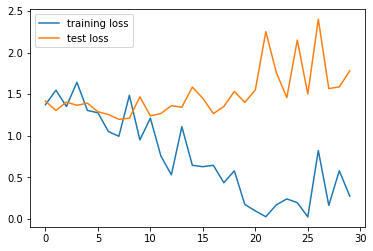

In [94]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')
plt.legend()

In [95]:
[t for t in test_correct]

[tensor(340),
 tensor(344),
 tensor(364),
 tensor(370),
 tensor(383),
 tensor(405),
 tensor(408),
 tensor(397),
 tensor(396),
 tensor(385),
 tensor(370),
 tensor(354),
 tensor(366),
 tensor(354),
 tensor(348),
 tensor(326),
 tensor(355),
 tensor(335),
 tensor(361),
 tensor(365),
 tensor(357),
 tensor(356),
 tensor(357),
 tensor(377),
 tensor(362),
 tensor(343),
 tensor(357),
 tensor(358),
 tensor(360),
 tensor(360)]

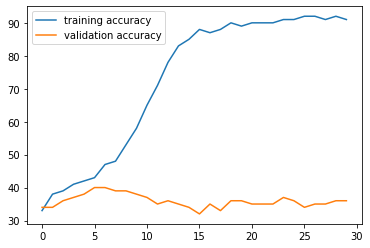

In [96]:
plt.plot([t/90 for t in train_correct], label='training accuracy')
plt.plot([t/10 for t in test_correct], label='validation accuracy')
plt.legend()

In [97]:
test_correct[-1].item()/1000

0.36